In [1]:
# 'capas', 'num_filtros', 'tam_filtros', 'num_frames'
EXP_FILE = './experiments/capas/1.pkl'
MODEL_NAME = 'fold-1'

FOLDER_TEST = './datasets/test/'

CLASSES = ['n', 's', 'e', 'w', 'cw', 'aw', 't']

WINDOW = 10
ELECTRODES = 24
TACTILE_IMAGE_ROWS = 12
TACTILE_IMAGE_COLS = 11
CHANNELS = 1

In [2]:
import numpy as np
import pickle
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-
#glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
#https://github.com/automan000/Convolution_LSTM_PyTorch

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.bias = bias
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding,  bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))

In [6]:
class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_sizes, num_classes, sequence_length,
                 dropout=0.25, bias=True):
        super(ConvLSTM, self).__init__()
        
        assert len(hidden_channels) == len(kernel_sizes)
        
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.num_layers = len(hidden_channels)
        self.sequence_length = sequence_length
        self.bias = bias
        self._all_layers = []
        
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_sizes[i], self.bias)
            
            setattr(self, name, cell)
            self._all_layers.append(cell)
            
            print(name)
            print(cell)
        
        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721
        self.avg_pool2d = nn.AvgPool2d((TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
        self.fc1 = nn.Linear(hidden_channels[-1], hidden_channels[-1])
        self.fc1_bn = nn.BatchNorm1d(hidden_channels[-1])
        self.fc1_drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, input):
        internal_state = []
        outputs = []
        
        for step in range(self.sequence_length):
            #print('#### step ', step)
            x = input[:, step, :, :, :]
            
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                
                if step == 0:
                    #print('init hidden')
                    #print('input', x.shape)
                    #print(name)
                    
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i], 
                                                             shape=(height, width))
                    #print('h', h.shape)
                    #print('c', c.shape)
                    
                    internal_state.append((h, c))
                    
                    #print('internal_state', len(internal_state))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
                
            # only record last steps
            #if step == self.sequence_length - 1:
            #    outputs.append(x)
            #    print('output', x.shape)
                
        #return outputs, (x, new_c)
        
        # Get last step and pass it to classifier
        out = self.avg_pool2d(x)
        out = torch.squeeze(out)
        #out = F.relu(self.fc1_bn(self.fc1(out)))
        out = F.relu(self.fc1(out))
        out = self.fc1_drop(out)
        out = self.fc2(out)

        return out

In [7]:
# Create ConvLSTM
hidden_channels = [16]
kernel_sizes = [3]
dropout = 0.0

convlstm = ConvLSTM(input_channels=CHANNELS, hidden_channels=hidden_channels, kernel_sizes=kernel_sizes,
                    num_classes=len(CLASSES), sequence_length=WINDOW, dropout=dropout).to(device)

cell0
ConvLSTMCell(
  (Wxi): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whi): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxf): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whf): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxc): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Whc): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (Wxo): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Who): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [8]:
checkpoint = torch.load(EXP_FILE + '.pt')

convlstm.load_state_dict(checkpoint[MODEL_NAME])

In [9]:
dataset_test = np.zeros((0, WINDOW, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
labels_test = np.zeros((0))
    
print(dataset_test.shape)
print(labels_test.shape)

for class_name in CLASSES:
    file = FOLDER_TEST + class_name + '-' + str(WINDOW) + '-ff'
    
    print(file)
    
    class_data = np.load(file + '-data-image.npy')
    class_labels = np.load(file + '-labels-image.npy')
    
    print(class_data.shape)
    print(class_labels.shape)
    
    dataset_test = np.append(dataset_test, class_data, axis=0)
    labels_test = np.append(labels_test, np.reshape(class_labels, (class_labels.shape[0])), axis=0)
    
    print(dataset_test.shape)
    print(labels_test.shape)

(0, 10, 12, 11)
(0,)
./datasets/test/n-10-ff
(221, 10, 12, 11)
(221, 1)
(221, 10, 12, 11)
(221,)
./datasets/test/s-10-ff
(220, 10, 12, 11)
(220, 1)
(441, 10, 12, 11)
(441,)
./datasets/test/e-10-ff
(222, 10, 12, 11)
(222, 1)
(663, 10, 12, 11)
(663,)
./datasets/test/w-10-ff
(220, 10, 12, 11)
(220, 1)
(883, 10, 12, 11)
(883,)
./datasets/test/cw-10-ff
(221, 10, 12, 11)
(221, 1)
(1104, 10, 12, 11)
(1104,)
./datasets/test/aw-10-ff
(222, 10, 12, 11)
(222, 1)
(1326, 10, 12, 11)
(1326,)
./datasets/test/t-10-ff
(220, 10, 12, 11)
(220, 1)
(1546, 10, 12, 11)
(1546,)


(array([0.16677447, 0.16601984, 0.16752911, 0.16601984, 0.16677447,
        0.16752911, 0.16601984]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

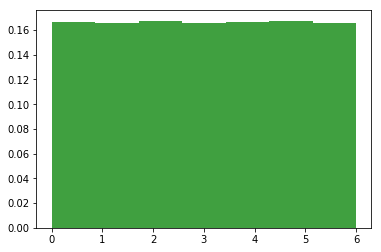

In [10]:
plt.hist(labels_test, bins=len(CLASSES), density=True, facecolor='g', alpha=0.75)

In [11]:
# Reshape data to include channels: batch, time, channels, height (rows), width (cols) 
dataset_test = dataset_test.reshape((dataset_test.shape[0], dataset_test.shape[1], CHANNELS, 
                                     dataset_test.shape[2], dataset_test.shape[3]))

print('Dataset test reshaped')
print(dataset_test.shape)

Dataset test reshaped
(1546, 10, 1, 12, 11)


In [12]:
# Changed for using GPU
dataset_test = torch.from_numpy(dataset_test)
dataset_test = dataset_test.to(device, dtype=torch.float)

labels_test = torch.from_numpy(labels_test)
labels_test = labels_test.to(device, dtype=torch.long)

In [13]:
with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
    outputs_test = convlstm(dataset_test)

_, predicted_test = torch.max(outputs_test.data, 1)

total_test = labels_test.size(0)
correct_test = (predicted_test == labels_test).sum().item()
score_test = correct_test / total_test

[precision_test, recall_test, f1_score_test, _] = precision_recall_fscore_support(labels_test, predicted_test,
                                                                                  average=None, pos_label=1)
    
print("accuracy:", score_test * 100)
print("precision:", precision_test * 100)
print("recall:", recall_test * 100)
print("f1_score:", f1_score_test * 100)

accuracy: 47.153945666235444
precision: [ 0.         51.44694534 77.89473684 84.61538462 18.4057971   0.
  0.        ]
recall: [  0.          72.72727273 100.         100.          57.46606335
   0.           0.        ]
f1_score: [ 0.         60.26365348 87.5739645  91.66666667 27.88144896  0.
  0.        ]


/home/brayan/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization


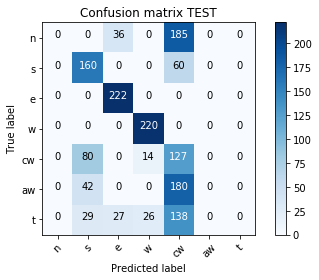

In [14]:
cnf_matrix_test = confusion_matrix(labels_test, predicted_test)

plt.figure()
plot_confusion_matrix(cnf_matrix_test, normalize=False, classes=CLASSES, title='Confusion matrix TEST')

In [16]:
with open(EXP_FILE + '-test', 'wb+') as f:
    # Test set information
    pickle.dump(FOLDER_TEST, f)

    pickle.dump(score_test, f)
    pickle.dump(precision_test, f)
    pickle.dump(recall_test, f)
    pickle.dump(f1_score_test, f)

    pickle.dump(cnf_matrix_test, f)